Import Modules

In [1]:
import pandas as pd
import numpy as np

import os
import seaborn as sns

import matplotlib.pyplot as plt
import librosa

import librosa.display
from IPython.display import Audio

import torchaudio
import torch

from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

Load Dataset

In [2]:
import kagglehub
path = kagglehub.dataset_download("jonathonbaroidev/brytserc")

print("Path to dataset files:", path)




100%|██████████| 1.06G/1.06G [00:50<00:00, 22.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jonathonbaroidev/brytserc/versions/1


In [ ]:
import re

extract_path = path
paths = []
labels = []

def extract_label(filename):
    filename = filename.split('.')[0]

    match = re.match(r'^[a-zA-Z]+', filename)
    if match:
        return match.group().lower()
    return None

for dirname, _, filenames in os.walk(extract_path):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = extract_label(filename)
        labels.append(label.lower())

print(f"Dataset Loaded: {len(paths)} files")

Dataset Loaded: 5215 files


In [4]:
len(paths)

5215

In [5]:
labels[:5]

['angry', 'angry', 'angry', 'sad', 'angry']

In [ ]:
df = pd.DataFrame()
df['audio_paths'] = paths
df['labels'] = labels
df

,audio_paths,labels
0,/root/.cache/kagglehub/datasets/jonathonbaroid...,angry
1,/root/.cache/kagglehub/datasets/jonathonbaroid...,angry
2,/root/.cache/kagglehub/datasets/jonathonbaroid...,angry
3,/root/.cache/kagglehub/datasets/jonathonbaroid...,sad
4,/root/.cache/kagglehub/datasets/jonathonbaroid...,angry
...,...,...
5210,/root/.cache/kagglehub/datasets/jonathonbaroid...,happy
5211,/root/.cache/kagglehub/datasets/jonathonbaroid...,surprise
5212,/root/.cache/kagglehub/datasets/jonathonbaroid...,neutral
5213,/root/.cache/kagglehub/datasets/jonathonbaroid...,sad


<Axes: xlabel='labels', ylabel='count'>

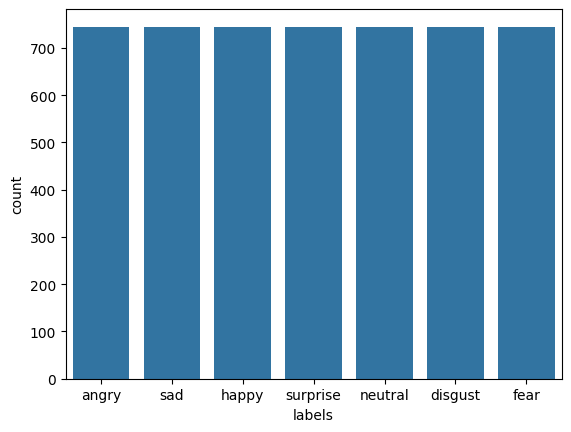

In [7]:
sns.countplot(data=df, x='labels')

In [ ]:
label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df['labels'] = df['labels'].map(label_map)
df

,audio_paths,labels
0,/root/.cache/kagglehub/datasets/jonathonbaroid...,0
1,/root/.cache/kagglehub/datasets/jonathonbaroid...,0
2,/root/.cache/kagglehub/datasets/jonathonbaroid...,0
3,/root/.cache/kagglehub/datasets/jonathonbaroid...,1
4,/root/.cache/kagglehub/datasets/jonathonbaroid...,0
...,...,...
5210,/root/.cache/kagglehub/datasets/jonathonbaroid...,2
5211,/root/.cache/kagglehub/datasets/jonathonbaroid...,3
5212,/root/.cache/kagglehub/datasets/jonathonbaroid...,4
5213,/root/.cache/kagglehub/datasets/jonathonbaroid...,1


In [ ]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=48000):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['labels']

        speech, sr = librosa.load(audio_path, sr=16000)

        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), constant_values=0)

        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncate=True, max_length=self.max_length)

        input_values = inputs.input_values.squeeze()
        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}

In [ ]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=2,
    stratify=df["labels"]
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.25,
    random_state=2,
    stratify=train_val_df["labels"]
)


In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=7)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = SpeechEmotionDataset(train_df, processor)
val_dataset = SpeechEmotionDataset(val_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Set Training Arguments

In [ ]:
from transformers import TrainingArguments, Trainer

class TrainValTrainer(Trainer):
    def evaluate(self, eval_dataset=None, **kwargs):
        results = super().evaluate(eval_dataset=eval_dataset, **kwargs)
        if eval_dataset is not self.train_dataset:
            train_results = super().evaluate(eval_dataset=self.train_dataset, metric_key_prefix="train")
            results.update(train_results)
        return results

In [28]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to=[],
    logging_strategy='epoch'
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
trainer = TrainValTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.575200,1.175195,0.684564,0.735870,0.684564,0.683096
2,1.012700,0.735814,0.828380,0.834052,0.828380,0.829368
3,0.721500,0.545233,0.869926,0.880137,0.869926,0.871050
4,0.534300,0.383235,0.916906,0.919441,0.916906,0.917039
5,0.416300,0.335567,0.916267,0.924344,0.916267,0.917459
6,0.319500,0.231055,0.950144,0.951175,0.950144,0.950098
7,0.239400,0.167386,0.964845,0.965495,0.964845,0.964903
8,0.184900,0.130535,0.973154,0.973704,0.973154,0.973219
9,0.153900,0.108911,0.978268,0.978496,0.978268,0.978297
10,0.127100,0.108459,0.977948,0.978212,0.977948,0.977973


TrainOutput(global_step=1960, training_loss=0.5284614368360869, metrics={'train_runtime': 2818.5269, 'train_samples_per_second': 11.102, 'train_steps_per_second': 0.695, 'total_flos': 8.5222282572e+17, 'train_loss': 0.5284614368360869, 'epoch': 10.0})

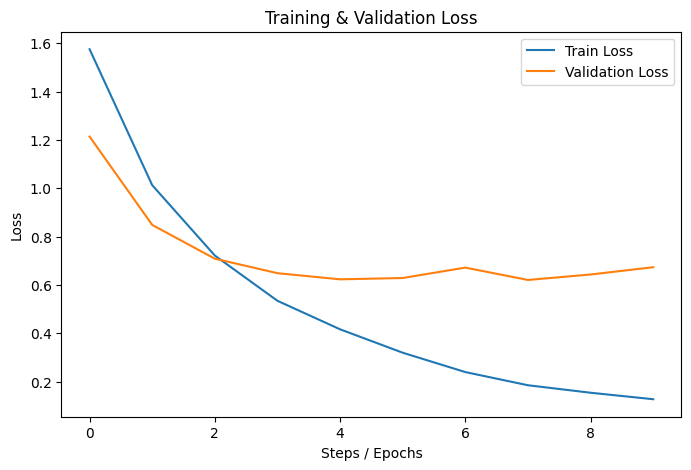

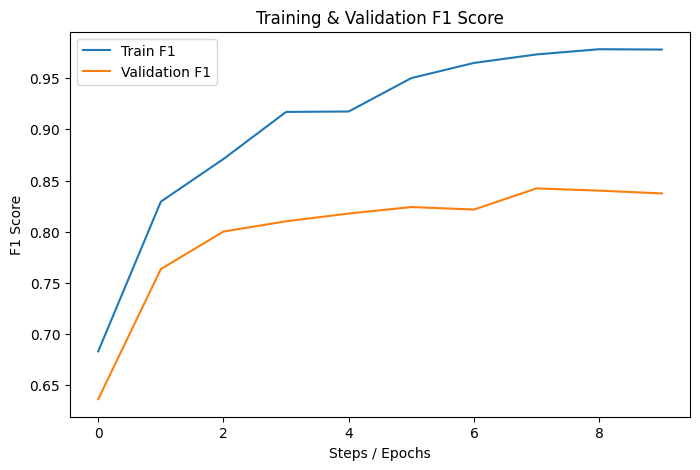

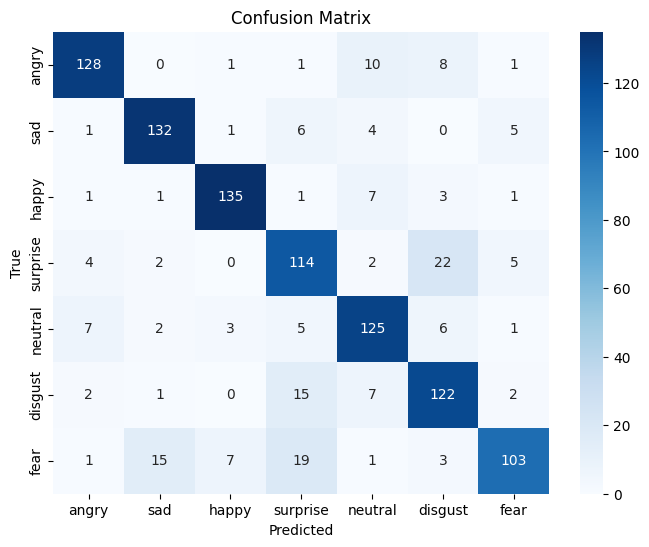

Classification Report:

              precision    recall  f1-score   support

       angry     0.8889    0.8591    0.8737       149
     disgust     0.7439    0.8188    0.7796       149
        fear     0.8729    0.6913    0.7715       149
       happy     0.9184    0.9060    0.9122       149
     neutral     0.8013    0.8389    0.8197       149
         sad     0.8627    0.8859    0.8742       149
    surprise     0.7081    0.7651    0.7355       149

    accuracy                         0.8236      1043
   macro avg     0.8280    0.8236    0.8238      1043
weighted avg     0.8280    0.8236    0.8238      1043



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

train_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Steps / Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

train_f1 = [log['train_f1'] for log in trainer.state.log_history if 'train_f1' in log]
eval_f1 = [log['eval_f1'] for log in trainer.state.log_history if 'eval_f1' in log]

if train_f1 and eval_f1:
    plt.figure(figsize=(8,5))
    plt.plot(train_f1, label='Train F1')
    plt.plot(eval_f1, label='Validation F1')
    plt.xlabel('Steps / Epochs')
    plt.ylabel('F1 Score')
    plt.title('Training & Validation F1 Score')
    plt.legend()
    plt.show()
else:
    print("F1 metrics were not logged during training. You can calculate them manually per epoch if needed.")

results = trainer.predict(test_dataset)

preds = np.argmax(results.predictions, axis=1)
labels = results.label_ids

pred_label_names = [inverse_label_map[p] for p in preds]
true_label_names = [inverse_label_map[l] for l in labels]

cm = confusion_matrix(true_label_names, pred_label_names, labels=list(inverse_label_map.values()))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(inverse_label_map.values()),
            yticklabels=list(inverse_label_map.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(true_label_names, pred_label_names, digits=4))


Test Predictions

In [41]:
import random
idx = random.randrange(0, len(test_dataset))

print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)

logits = outputs.logits

predicted_class = logits.argmax(dim=-1).item()
print("Predicted Label:", inverse_label_map[predicted_class])

Original Label: happy
Predicted Label: happy
